# Objetivo:
Acessar o site https://portal.gupy.io/, fazer um web scraping de todas as vagas de emprego abertas e botar essa informação num arquivo csv. As features extraídas de cada vaga são à escolha do desenvolvedor.

Vale ressaltar que o site https://portal.gupy.io/robots.txt diz que todos os agentes tem permissão para acessar todos os sites.


## Análise Exploratória:
Para começar, foi feita uma análise de algumas coisas:
- Pesqusa sobre a API do gupy.
- Inspecionar elemento no Chrome.
- Pesquisa sobre web scraping.

Com isso, foram aprendidas algumas informações importantes:
- A API do gupy aparentemente tem todos os jobs disponíveis. Documentação: https://developers.gupy.io/reference/findjobs
- A API do gupy é inutilizável pois depende do plano Premium/Enterprise. https://developers.gupy.io/reference/authentication
  - Consequentemente, é necessário descobrir outra forma de acessar todos os jobs em aberto.
- Há uma árvore body/div/div/div/div/main/ul com a lista dos resultados da pesquisa, e cada "li" é um job que possui as informações desejadas.
  - Problema: numa busca a página carrega com apenas os 10 primeiros jobs, e o resto é carregado pelo javascript posteriormente.
- Testando as pesquisas, foi descoberto que a pesquisa é aparentemente feita exclusivamente do título da vaga, o que dificulta achar todas as vagas em aberto.
- Pesquisando web scraping, chegou-se a conclusão de que é bem fácil importar o html de uma página pra uma variável. Entretando, isso não resulta no scraping completo por conta do carregamento posterior com javascript (infinite scrolling).
  - Pelas pesquisas, o recomendado nesse caso é utilizar a biblioteca "Selenium".

Assim, foram encontrados alguns desafios a serem resolvidos:
- Aprender a utilizar a biblioteca Selenium.
- Transformar uma string de todo o HTML em uma tabela com as informações relevantes. Para fazer o parsing do HTML, é necessário aprender a utilizar a biblioteca BeautifulSoup.
- Durante a resolução, foi descoberto que algumas classes são estáticas e outras são dinâmicas, então pra lidar com as dinâmicas foi preciso aprender um pouco de Regular Expressions.
- Obter uma lista de todos os jobs disponíveis.
  - Para facilitar o projeto, irá ser feito o web scraping apenas em resultados de pesquisa, aí é só escolher o que pesquisar pra achar as vagas relevantes.

In [1]:
# Antes de começar. importamos as bibliotecas necessárias pra tudo que utilizaremos
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service as ChromeService
from webdriver_manager.chrome import ChromeDriverManager
import time

## Primeiro passo: Transformar HTML -> Lista
Foi criada uma função para transformar as informações extraídas em uma lista, pra posteriormente serem exportadas pra um DataFrame e posteriormente um CSV.

In [2]:
# Foram escolhidas 7 características para serem extraídas dos jobs.
# Título, Empresa, Localização, Modelo de trabalho (remoto ou presencial), Tipo de contrato (efetivo, estagiário etc),
# PCD (se a empresa tem vagas afirmativas para PCD), e Data da postagem da vaga.
column_names = ["job_title", "company", "location", "work_model", "contract_type", "pcd", "date"]

In [3]:
# A função recebe como entrada uma variável string do HTML de uma página e retorna uma lista de listas.
def html_to_list(html):
    
    # Primeiramente, transformamos o HTML em um objeto da biblioteca BeautifulSoup.
    soup = BeautifulSoup(html, "html.parser")
    
    # Existem informações desejadas em classes estáticas e em classes dinâmicas que mudam toda vez que acessa o site.
    # Para acessar as de classe dinâmica, é utilizado expressões regulares.
    # A primeira parte (sc-...) é o começo da string, enquanto [^\"]* é tudo até aparecer um '"'.
    # É chamado a função search da biblioteca re para achar essas strings.
    job_title_re = "sc-llJcti jgKUZ[^\"]*"
    company_re = "sc-efBctP dpAAMR[^\"]*"
    job_title_class = re.search(job_title_re, str(soup.main.ul.find_all("li")[0]))[0]
    company_class = re.search(company_re, str(soup.main.ul.find_all("li")[0]))[0]
    extra_infos_class = "sc-23336bc7-1 cezNaf"
    date_class = "sc-efBctP dpAAMR sc-1db88588-0 inqtnx"
    
    # É criado uma job_list que é preenchida com listas (temp_job_list).
    # Cada elemento de temp_job_list é uma feature, e às vezes a informação sobre PcD não existe, então é preenchido com N/A
    # Cada elemento de job_list é um trabalho com todas as features extraídas.
    job_list = []
    for job in soup.main.ul.find_all("li"):
        temp_job_list = []
        temp_job_list.append(job.find("h2", {"class": job_title_class}).string)
        temp_job_list.append(job.find("p", {"class": company_class}).string)
        for object in job.find_all("span", {"class": extra_infos_class}):
            temp_job_list.append(object.string)
        if len(temp_job_list) == 5:
            temp_job_list.append("N/A")
        temp_job_list.append(job.find("p", {"class": date_class}).string)
        job_list.append(temp_job_list)
    
    return job_list

## Segundo passo: Importar os resultados de uma busca
Nessa seção, irei utilizar Selenium para pegar todos os resultados de uma busca. 

In [4]:
# Como não foi possível obter um site com a lista de todos os jobs, serão feitas 5 buscas
# para exemplificar o scraping dos jobs em aberto. Os termos foram escolhidos de forma arbitrária.
url = "https://portal.gupy.io/job-search/term="
search_term = ["dados", "engenharia", "TI", "computação", "informática"]

In [5]:
# A biblioteca Selenium abre um navegador virtual. Utilizamos a opção headless pra não abrir uma guia visualmente, só no console.
# Aqui inicializamos o driver pra abrir esse navegador virtual.
options = webdriver.ChromeOptions()
options.add_argument("--headless=new")
driver = webdriver.Chrome(service=ChromeService(
    ChromeDriverManager().install()), options=options)

In [6]:
# Esse bloco faz a requisição de dados pelo Selenium com os termos de pesquisa e salva o HTML de cada página.
html = []
for search in search_term:
    
    # Primeiro, abre-se o driver.
    driver.get(url + search)

    # É salvo a altura inicial da página pra fazer o infinite scrolling.
    last_height = driver.execute_script('return document.body.scrollHeight')

    while True:
        # Dá scroll pra baixo e espera meio segundo pra carregar os jobs novos.
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        time.sleep(0.5)
        
        # Após o carregamento, é checada a altura nova.
        # Se não tiver aumentado, quer dizer que já carregou todos os jobs dessa pesquisa.
        new_height = driver.execute_script('return document.body.scrollHeight')
        if new_height == last_height:
            break
        
        # Se não tiverem sido carregados, atualiza-se a altura e repete o processo.
        last_height = new_height
    
    # Com a pesquisa terminada, o HTML é salvo na variável html.
    html.append(driver.page_source)

## Terceiro passo: Montar o DataFrame e checar informações duplicadas
Aqui é feita a montagem do DataFrame pra depois ser exportado e um leve pré-tratamento de dados.

In [7]:
# Cria-se o dataframe jobs_df, concatenando todos os resultados de pesquisa no dataframe.
jobs_df = pd.DataFrame(columns=column_names)
for page in html:
    scrapped_list = html_to_list(page)
    temp_df = pd.DataFrame(scrapped_list, columns=column_names)
    jobs_df = pd.concat([jobs_df, temp_df])

In [8]:
# Observando um pouco o dataframe.
jobs_df

,job_title,company,location,work_model,contract_type,pcd,date
0,Administrador de Banco de Dados Oracle,JDC Tech,Belo Horiz... - MG,Remoto,Efetivo,Também p/ PcD,Publicada em: 09/08/2023
1,Analista de Dados - Foco em Precificação de Cr...,Tech Sicredi,Porto Alegre - RS,Remoto,Efetivo,Também p/ PcD,Publicada em: 09/08/2023
2,Engenheiro de Dados,JDC Tech,Não informado,Remoto,Efetivo,Também p/ PcD,Publicada em: 09/08/2023
3,Analista de Dados Sênior,Poliedro Educação,São José d... - SP,Remoto,Efetivo,Também p/ PcD,Publicada em: 09/08/2023
4,Cientista de Dados - Foco Concessão de Crédito,Tech Sicredi,Porto Alegre - RS,Remoto,Efetivo,Também p/ PcD,Publicada em: 09/08/2023
...,...,...,...,...,...,...,...
71,ESPECIALISTA DE SISTEMAS - Informatica Cloud,3corações,Eusébio - CE,Remoto,Efetivo,Também p/ PcD,Publicada em: 13/03/2023
72,TECNICO DE INFORMATICA JR,Instituto Sírio-Libanês,São Paulo - SP,Presencial,Banco de Talentos,Também p/ PcD,Publicada em: 03/02/2023
73,Banco de Talentos - Informática,Covre Transportes e Logística,Limeira - SP,Presencial,Banco de Talentos,Também p/ PcD,Publicada em: 17/01/2023
74,Técnico de Informática (Vaga Afirmativa para P...,Solutis Tecnologias LTDA,Não informado,Remoto,Banco de Talentos,Também p/ PcD,Publicada em: 07/12/2022


In [9]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2031 entries, 0 to 75
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   job_title      2031 non-null   object
 1   company        2031 non-null   object
 2   location       2031 non-null   object
 3   work_model     2031 non-null   object
 4   contract_type  2031 non-null   object
 5   pcd            2031 non-null   object
 6   date           2031 non-null   object
dtypes: object(7)
memory usage: 126.9+ KB


In [10]:
# Tiramos os elementos duplicados, ajeitamos o formato da data e atualizamos o index.
jobs_df.drop_duplicates(inplace=True)
jobs_df['date'] = pd.to_datetime(jobs_df['date'], format="Publicada em: %d/%m/%Y")
jobs_df.set_index(['job_title'], inplace=True)

## Quarto passo: Montar gráficos simples com o resultado
Foram montados alguns gráficos bem simples (sem tratamento de dados e sem muitos detalhes) só pra ter uma rápida visualização dos resultados obtidos.

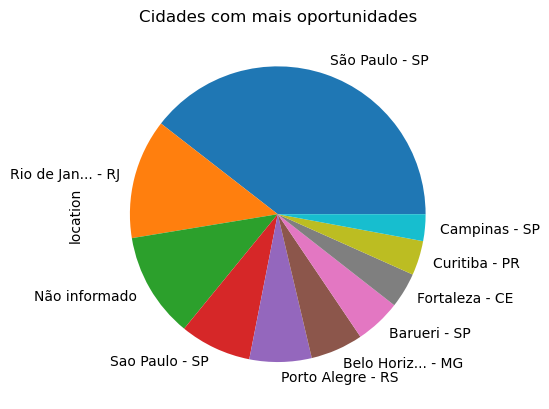

In [11]:
jobs_df['location'].value_counts().head(10).plot(kind='pie', title="Cidades com mais oportunidades")
plt.show()

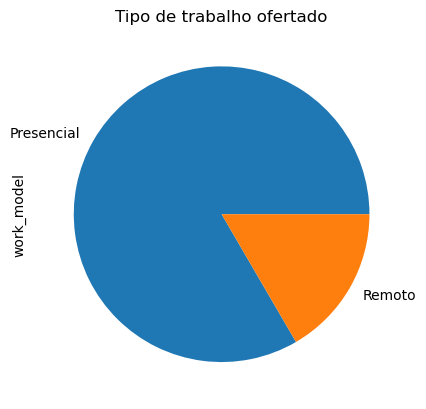

In [12]:
jobs_df['work_model'].value_counts().plot(kind='pie', title="Tipo de trabalho ofertado")
plt.show()

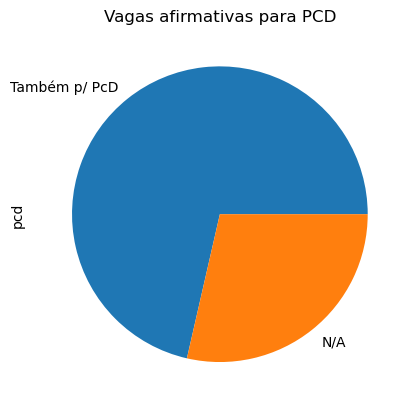

In [13]:
jobs_df['pcd'].value_counts().plot(kind='pie', title="Vagas afirmativas para PCD")
plt.show()

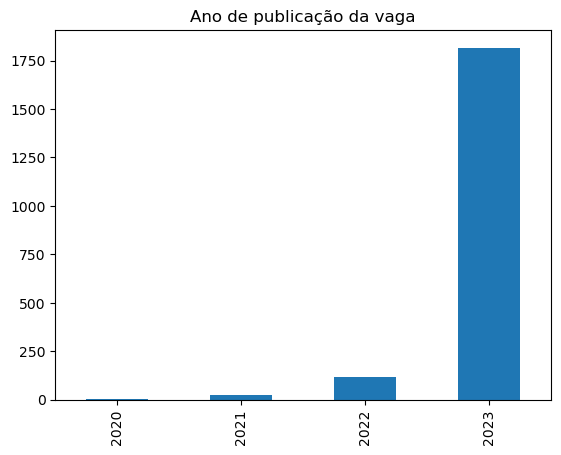

In [14]:
jobs_df['date'].dt.year.value_counts().sort_index().plot(kind='bar', title="Ano de publicação da vaga")
plt.show()

## Quinto passo: Exportar os resultados
Com tudo feito, exportaremos os resultados para CSV.

In [16]:
jobs_df

,company,location,work_model,contract_type,pcd,date
job_title,,,,,,
Administrador de Banco de Dados Oracle,JDC Tech,Belo Horiz... - MG,Remoto,Efetivo,Também p/ PcD,2023-08-09
Analista de Dados - Foco em Precificação de Crédito,Tech Sicredi,Porto Alegre - RS,Remoto,Efetivo,Também p/ PcD,2023-08-09
Engenheiro de Dados,JDC Tech,Não informado,Remoto,Efetivo,Também p/ PcD,2023-08-09
Analista de Dados Sênior,Poliedro Educação,São José d... - SP,Remoto,Efetivo,Também p/ PcD,2023-08-09
Cientista de Dados - Foco Concessão de Crédito,Tech Sicredi,Porto Alegre - RS,Remoto,Efetivo,Também p/ PcD,2023-08-09
...,...,...,...,...,...,...
ESPECIALISTA DE SISTEMAS - Informatica Cloud,3corações,Eusébio - CE,Remoto,Efetivo,Também p/ PcD,2023-03-13
TECNICO DE INFORMATICA JR,Instituto Sírio-Libanês,São Paulo - SP,Presencial,Banco de Talentos,Também p/ PcD,2023-02-03
Banco de Talentos - Informática,Covre Transportes e Logística,Limeira - SP,Presencial,Banco de Talentos,Também p/ PcD,2023-01-17


In [15]:
jobs_df.to_csv("./resultados_gupy.csv")